In [1]:
# filepaths
import os
from os.path import basename

# Regular expressions
import glob
import re

# main modelling
import multiprocessing
import gensim.models.word2vec as w2v

import numpy as np

# reduction and display
#import sklearn.manifold
#import pandas as pd

# Split Train/Test
from sklearn.model_selection import train_test_split

# plotting data
#import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from IPython.display import clear_output

# debug time output
import time

d:\projects\007-anaconda\envs\tensorflow_gpu\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import os
os.environ['KERAS_BACKEND'] = "tensorflow"

import tensorflow as tf
import keras
from keras import backend
from keras.models import load_model
from keras.models import Sequential 
from keras.layers.recurrent import LSTM, SimpleRNN

d:\projects\007-anaconda\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)
print("Keras Backend:", keras.backend.backend())

TensorFlow Version: 1.8.0
Keras Version: 2.1.6
Keras Backend: tensorflow


In [4]:
# -------------------------------------------------------------------------------------------------
# Sentence Text Processing
# -------------------------------------------------------------------------------------------------

def legal_char_for_char(c):
    if   c == '\n': return ' '
    return c

def sentence_to_wordlist(sent):
    cleansent = re.sub("[^a-zA-Z]"," ", sent)
    words = cleansent.split()
    return words

def sentence_end_char(c):
    if   c == '.':  return True
    elif c == '?':  return True
    elif c == '!':  return True
    return False

def mid_sentence_abbr(str):
    if   str.endswith("Mr."): return True
    elif str.endswith("Mrs."): return True
    elif str.endswith("Dr."): return True
    elif str.endswith("etc."): return True
    elif str.endswith("ie."): return True
    return False

def import_textfile_to_sentencelist(filepath):
    accumulated_sentence = ""
    sentencelist = []
    c = ' '
    with open (filepath, "r") as f:
        while c: 
            c = f.read(1)
            accumulated_sentence += legal_char_for_char(c)

            if ( (sentence_end_char(c)) and not (mid_sentence_abbr(accumulated_sentence)) ):
                sentencelist.append(accumulated_sentence.strip())
                accumulated_sentence = ""
    return sentencelist

def import_textfile_to_linelist(filepath):
    with open (filepath, "r") as f:
        content = f.readlines()
    content = [x.strip('\n') for x in content] 
    return content

In [5]:
w2v_model = w2v.Word2Vec.load('fullw2v_d250_v85000.w2v')
w2vDimension = 250

In [6]:
# Crash protection function, for any word we can't lookup, we substitute an unk.

def w2v_vect_for_word(text):
    text = text.lower()
    if (currword in w2v_model):
        return w2v_model[text]
    else:
        return w2v_model['unk']

In [7]:
wordchecklist = ['UNK', 'Hello', '12121221ADWADASD']

for currword in wordchecklist:
    currword = currword.lower()
    if (currword in w2v_model):
        print ('    {} found'.format(currword))    
    else:
        print ('*** {} not found'.format(currword))    


    unk found
    hello found
*** 12121221adwadasd not found


In [8]:
# load the Q/A sentence files
q_filelist = glob.glob("../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset/*-q.txt")
a_filelist = glob.glob("../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset/*-a.txt")

print(q_filelist[0])
print(a_filelist[0])

print(len(q_filelist), "files")

../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\dialog_esl_conversations-q.txt
../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\dialog_esl_conversations-a.txt
15 files


In [9]:
# take the book list, and create a list of text sentences
full_qlinelist = []
full_alinelist = []
for currfile in q_filelist:
    print("Processing q-file: {}".format(currfile))
    full_qlinelist.extend(import_textfile_to_linelist(currfile))
for currfile in a_filelist:
    print("Processing a-file: {}".format(currfile))
    full_alinelist.extend(import_textfile_to_linelist(currfile))
    
print("q-linelist total:{}".format(len(full_qlinelist)))
print("a-linelist total:{}".format(len(full_alinelist)))

Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\dialog_esl_conversations-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\simpledialog-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-102-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-103-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-104-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-105-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-106-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-107-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDataset\st-ng-108-q.txt
Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges/001-ControlledDatase

In [10]:
# take the list of q & a line, and produce and list of lists of words
q_wordlist = []
a_wordlist = []
for currline in full_qlinelist:
    currline = currline.lower()
    words = sentence_to_wordlist(currline)
    q_wordlist.append(words)
for currline in full_alinelist:
    currline = currline.lower()
    words = sentence_to_wordlist(currline)
    a_wordlist.append(words) 
    
print (q_wordlist[0])  
print (a_wordlist[0])  

['hi', 'how', 'are', 'you', 'doing']
['i', 'm', 'fine', 'how', 'about', 'yourself']


In [11]:
# Crop / Pad word lists at a fixed number of words

WordPerSentenceLimit = 12

q_limitedwordlist = []
a_limitedwordlist = []

for currline in q_wordlist:
    currlinelen = len(currline)
    if currlinelen < WordPerSentenceLimit:
        for i in range (WordPerSentenceLimit - currlinelen):
            currline.append('unk')
    if currlinelen > WordPerSentenceLimit:
        currline = currline[0:WordPerSentenceLimit-1]
    q_limitedwordlist.append(currline)

for currline in a_wordlist:
    currlinelen = len(currline)
    if currlinelen < WordPerSentenceLimit:
        for i in range (WordPerSentenceLimit - currlinelen):
            currline.append('unk')
    if currlinelen > WordPerSentenceLimit:
        currline = currline[0:WordPerSentenceLimit-1]
    a_limitedwordlist.append(currline)
    
print (q_limitedwordlist[0])
print (a_limitedwordlist[0])


['hi', 'how', 'are', 'you', 'doing', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk']
['i', 'm', 'fine', 'how', 'about', 'yourself', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk']


In [12]:
print (len(q_limitedwordlist))
print (len(q_limitedwordlist[0]))

dim1 = len(q_limitedwordlist)
dim2 = WordPerSentenceLimit
dim3 = w2vDimension

range1 = dim1-1
range2 = dim2-1
range3 = dim3

q_np_vlist = np.zeros( (dim1,dim2,dim3) )
a_np_vlist = np.zeros( (dim1,dim2,dim3) )

for i1 in range(range1):
    currsent = q_limitedwordlist[i1]
    for i2 in range(range2):
        currword = currsent[i2]
        currvect = w2v_vect_for_word(currword)
        for i3 in range(range3):
            q_np_vlist[i1][i2][i3] = currvect[i3]

for i1 in range(range1):
    currsent = a_limitedwordlist[i1]
    for i2 in range(range2):
        currword = currsent[i2]
        currvect = w2v_vect_for_word(currword)
        for i3 in range(range3):
            a_np_vlist[i1][i2][i3] = currvect[i3]


4881
12


In [13]:
# updatable plot# updat 
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):

    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    def on_train_begin(self, logs={}):
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [14]:
# Split the data into train and test

qtrain_vlist, qtest_vlist, atrain_vlist, atest_vlist = train_test_split(q_np_vlist, a_np_vlist, test_size=0.2, random_state=1 )

In [15]:
# Create the model

model=Sequential()
model.add(LSTM(input_shape=(WordPerSentenceLimit, w2vDimension), return_sequences=True, activation="sigmoid", units=w2vDimension, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal", dropout=0.01, go_backwards=False) )
model.add(LSTM(input_shape=(WordPerSentenceLimit, w2vDimension), return_sequences=True, activation="sigmoid", units=w2vDimension, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal", dropout=0.01, go_backwards=True ) )
model.add(LSTM(input_shape=(WordPerSentenceLimit, w2vDimension), return_sequences=True, activation="sigmoid", units=w2vDimension, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal", dropout=0.01, go_backwards=False) )
model.add(LSTM(input_shape=(WordPerSentenceLimit, w2vDimension), return_sequences=True, activation="sigmoid", units=w2vDimension, kernel_initializer="glorot_normal", recurrent_initializer="glorot_normal", dropout=0.01, go_backwards=True ) )

model.compile(loss='cosine_proximity', optimizer='adam', metrics=['accuracy'])
model.summary()

iteration = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 250)           501000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 250)           501000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 250)           501000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 250)           501000    
Total params: 2,004,000
Trainable params: 2,004,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Don't run this block on the first pass. Run it on later passes to load and continue training the model. 
# The overall loss value on the graph should continue to decrease in the same manner, giving some confidence the load worked ok.

iteration = 110
filename = "bot_E{}.h5".format(iteration)

model = load_model(filename)
WordPerSentenceLimit = 12

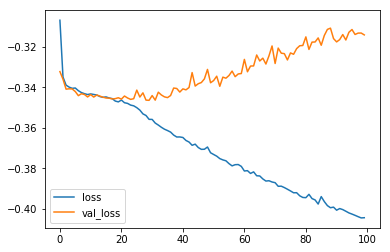

In [16]:
num_epochs = 100
iteration += num_epochs

model.fit(qtrain_vlist, atrain_vlist, 
          epochs=num_epochs, 
          validation_data=(qtest_vlist, atest_vlist), 
          callbacks=[plot_losses])

filename = "bot_E{}.h5".format(iteration)
model.save(filename)